# Background
This notebook goes through the off position reduction in class for the orion B map

In [4]:
from IPython.display import HTML

HTML('''
// http://lokeshdhakar.com/projects/lightbox2
<link href="./notebook_support/lightbox2-master/dist/css/lightbox.css" rel="stylesheet">

<script src="./notebook_support/lightbox2-master/dist/js/lightbox.js"></script>

<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# import commands

In [190]:
## import
from astropy.io import fits

import numpy as np
import glob
import datetime
import pandas as pd
import logging
import os,re
import time
import subprocess
import cygrid
import matplotlib.pyplot as plt
from matplotlib.lines import lineStyles
from astropy.io import fits
from astropy import units as u
import jinja2
import requests

# notebook
from IPython.display import Image, display
from IPython.display import HTML
# astropy
from astropy.io import fits
from astropy import constants as const
from astropy import units as u

plt.rcParams['figure.figsize'] = (15.0, 7.0)

def PrintMessage(message):
    html='''
    <table style="width:100%">
        <tr>
            <td style='text-align:center;vertical-align:middle'>{0}</td>
        </tr>
    </table>
    '''
    display(HTML(html.format(message)))


def Change1dListTo2dList(array, column=2):
    test = []
    test_row = []
    for item in array:
        test_row.append(item)
        if len(test_row)> column-1:
            test.append(test_row)
            test_row = []
    if len(test_row)>0:
        test.append(test_row)
    return test

def DisplayImagesInColumns(images,image_columns=2, gallery_label=""):
    popup_css='''    
    
    <style>
    .thumb img { 
        border:1px solid #000;
        margin:3px;    
        float:left;
    }
    .thumb span { 
        position:fixed;
        visibility:hidden;
    }
    .thumb:hover, .thumb:hover span { 
        visibility:visible;
        z-index:1;
    }

    </style>

    '''
    
    html='''    
    <a href={0} target="_blank">
    <img style='width: {1:2.0f}%; margin: 0px; float: left; border: 0px solid black;' src='{0}?{2}' />
    </a>
    '''
    html='''    
    <a href={0}  target="_blank">
    <img style='width: {1:2.0f}%; margin: 0px; float: left; border: 0px solid black;' src='{0}?{2}' />
    </a>
    '''
    
    #html='''    
    #<a href={0}  data-lightbox={3} data-title="{0}">
    #<img style='width: {1:2.0f}%; margin: 0px; float: left; border: 0px solid black;' src='{0}?{2}' />
    #</a>
    #'''
    
    list2d = Change1dListTo2dList(images, column=image_columns)
    width_percent = (1/float(image_columns))*100.0
    gallery_label = gallery_label.replace(" ","")
    for row in list2d:
        imagesList=popup_css.join( [html.format(image,width_percent-2,time.time(),gallery_label) 
                     for image in row ])
        display(HTML(imagesList))
    return imagesList
   

# Helper Class to run class_cmd_strings and export the images that were created to the notebook
class RunClassScript():
    def __init__(self, cmd, no_output=False, display_images=True, test=False):
        self.cmd = cmd
        self.cmd_file = "/tmp/cmd.class"
        self.cmd_log = "/tmp/cmd.log"
        self.images = [string.split()[1].replace("\"","").replace("//","/") for string in self.cmd.split("\n") if string[0:2] == "ha"]
        if self.cmd.split("\n")[-1].strip() != "exit 0":
            self.cmd = "{}\nexit 0\n".format(self.cmd)
        subprocess.call(["rm", "-rf", "/tmp/cmd.class"])
        fileout = open(self.cmd_file, "w")
        fileout.write(self.cmd)
        fileout.close()
        #output = subprocess.check_output("class -nw @{0}".format(self.cmd_file), shell=True)
        if test:
            print(self.cmd)
        try:
            output = subprocess.check_call("class -nw @{0} > {1}".format(self.cmd_file,self.cmd_log), shell=True)
        except subprocess.CalledProcessError as e:
            print("======================================")
            print("=========== ERROR in class cmd =======")
            print("======================================")
            print("\n")
            print("======================================")
            print("============= INPUT FILE =============")
            print("======================================")
            with open(self.cmd_file, 'r') as fin:
                for line in fin.readlines():
                    if line[0]!=" ":
                        print(line.strip("\n"))
            print("======================================")
            print("========= OUTPUT LOGFILE =============")
            print("======================================")                        
            with open(self.cmd_log, 'r') as fin:
                for line in fin.readlines():
                    if (len(set(line))>1):
                        print(line.strip("\n"))
            raise subprocess.CalledProcessError(e.returncode,e.cmd, e.output)
        if output!=0:
            print(output)
            self.output=output
        #
        if display_images:
            for image in self.images:
                if os.path.exists(image):
                    #display(image, Image(image),width=300,height=300)
                    display(image, Image(image))
def GenerateGIFAnimation(images,gif_filename):
    convert_cmd = "convert -delay 50"\
                  " -loop 0 "\
                  "{0} "\
                  "{1}".format(images,gif_filename)
    os.system(convert_cmd)
    

    from IPython.display import HTML

def download_file(url,local_filename):
    #local_filename = url.split('/')[-1]
    r = requests.get(url)
    f = open(local_filename, 'wb')
    for chunk in r.iter_content(chunk_size=512 * 1024): 
        if chunk: # filter out keep-alive new chunks
            f.write(chunk)
    f.close()
    return 

def show_file_content(file, num_lines=10):
    ''' To show class console output '''
    a_file = open(file, "r")
    lines = a_file.readlines()
    last_lines= lines[-num_lines:]
    for line in last_lines:
        print(line)

# Download test data from archive



In [24]:
data_folder = "./tmp/data"


if not os.path.exists(data_folder):
    print("making folder {0}".format(data_folder))
    #os.makedirs(data_folder)
    os.makedirs(data_folder,exist_ok=True)
    
urls = []
#urls.append("https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC4K/20161110_F348/proc/p8486/data/2016-11-10_GR_F348_04_0066_0010505_1900536.9.great.tar")
urls.append("https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC5A/20170208_F371/proc/p4006/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9.great.tar")

for url in urls:
    filename = "{0}/{1}".format(data_folder,url.split('/')[-1])
    if not os.path.exists(filename):
        print("downloading {0} to {1}".format(url, filename))
        download_file(url, filename)
    else:
        print("{1} already downloaded".format(url, filename))
# untar
already_downloaded_great = glob.glob("tmp/data/**/*.great")
#
for url in urls:
    # check for great file
    tar_filename = "{0}/{1}".format(data_folder,url.split('/')[-1])
    filename_great,ext = os.path.splitext(tar_filename)
    full_filename_great,ext = os.path.splitext(os.path.basename(filename_great))
    #
    found = [filename for filename in  already_downloaded_great if full_filename_great in filename]
    if len(found)>0:
        print(" {0} already extracted".format(full_filename_great))
    else:
        print(" {0} extracting".format(full_filename_great))
        #cmd="tar -xvf {0} --wildcards --no-anchored '*Tmb.great' --one-top-level={1}".format(tar_filename,data_folder)
        cmd="tar -xvf {0} --one-top-level={1}".format(tar_filename, data_folder)
        print(cmd)
        output = subprocess.check_call(cmd, shell=True)

downloading https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC5A/20170208_F371/proc/p4006/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9.great.tar to ./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9.great.tar
 2017-02-08_GR_F371_04_0066_0010505_1900536.9 extracting
tar -xvf ./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9.great.tar --one-top-level=./tmp/data


#  THE PRODUCTS #
## LEVEL 3 DATA ###

2 **.great** files:

- Scientific target spectra in units of Antenna Temperature and additional output spectra.
- Scientific target spectra only, in units of Main Beam Temperature.


### Antenna Temperature file ###

In [191]:
cmd = '''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
list
'''

In [192]:
output = RunClassScript(cmd)

In [193]:
show_file_content('/tmp/cmd.log', 100)

15749;4 TSYS         CII_L        SOF-LFAV_6_S   -732.2   -904.8 Eq 18251 5

15750;4 TAU_SIG      CII_L        SOF-LFAV_6_S   -732.2   -904.8 Eq 18251 5

15751;4 TAU_IMG      CII_L        SOF-LFAV_6_S   -732.2   -904.8 Eq 18251 5

15752;4 TAU_AVG      CII_L        SOF-LFAV_6_S   -732.2   -904.8 Eq 18251 5

15753;4 S-H_OBS      CII_L        SOF-LFAV_6_S   -732.2   -904.8 Eq 18251 5

15754;4 SKY-DIFF     CII_L        SOF-LFAV_6_S   -732.2   -904.8 Eq 18251 5

15755;4 S-H_FIT      CII_L        SOF-LFAV_6_S   -732.2   -904.8 Eq 18251 5

15756;4 OMC_CENTER   CII_L        SOF-LFAV_6_S   +215.3   -218.7 Eq 18251 8

15757;4 OMC_CENTER   CII_L        SOF-LFAV_6_S   +215.3   -213.5 Eq 18251 8

15758;4 OMC_CENTER   CII_L        SOF-LFAV_6_S   +215.3   -208.3 Eq 18251 8

15759;4 OMC_CENTER   CII_L        SOF-LFAV_6_S   +215.3   -203.1 Eq 18251 8

15760;4 OMC_CENTER   CII_L        SOF-LFAV_6_S   +215.3   -197.9 Eq 18251 8

15761;4 OMC_CENTER   CII_L        SOF-LFAV_6_S   +215.3   -192.7 Eq 18251 8


## Additional Spectra ##

- Receiver temperature (TREC)
- System Temperature (TSYS)
- Sky-Hot spectra, Observed and fitted (S-H_OBS, S-H_FIT)

## example TREC spectrum ##

In [71]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
get 15469
pl
ha "./tmp/plots/trec.png" /dev png /overwr
'''

'./tmp/plots/trec.png'

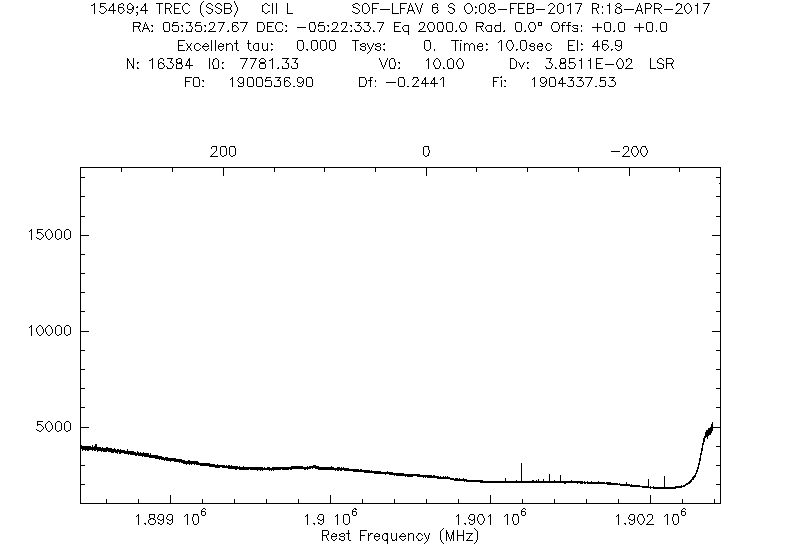

In [72]:
output=RunClassScript(cmd)


## example TSYS spectrum ##

In [82]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
get 15082
pl
ha "./tmp/plots/tsys.png" /dev png /overwr
'''

'./tmp/plots/tsys.png'

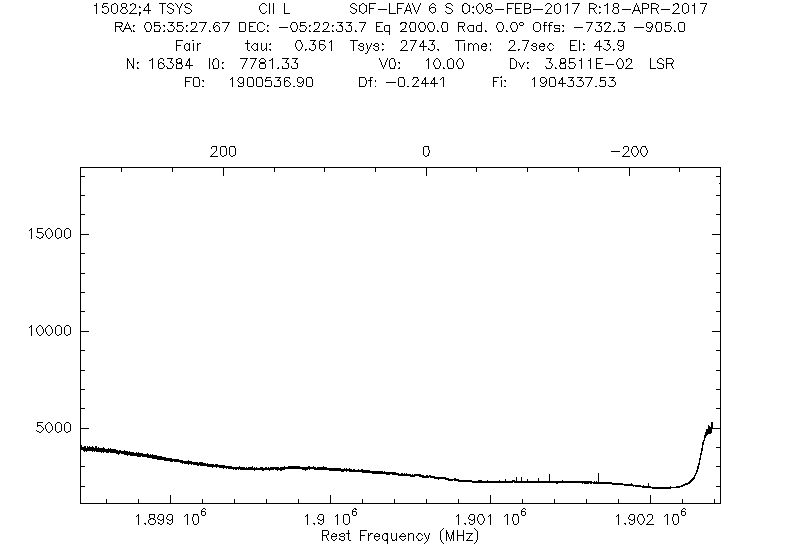

In [83]:
output=RunClassScript(cmd)


## example SKY-HOT_OBS spectra ##

In [75]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
get 14993
pl
ha "./tmp/plots/s_h.png" /dev png /overwr
'''

'./tmp/plots/s_h.png'

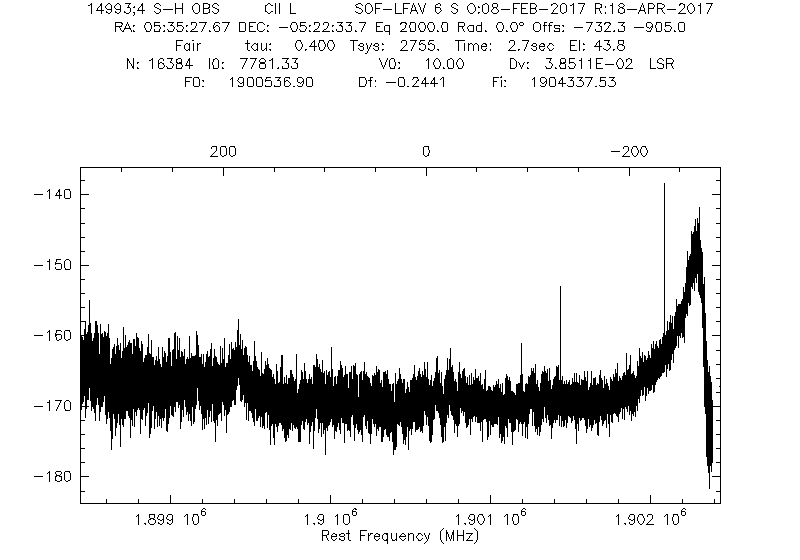

In [76]:
output=RunClassScript(cmd)


## example SKY-HOT_FIT spectra ##

In [78]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
get 14995
set mod y -180 -140
pl
ha "./tmp/plots/s_h_fit.png" /dev png /overwr
'''

'./tmp/plots/s_h_fit.png'

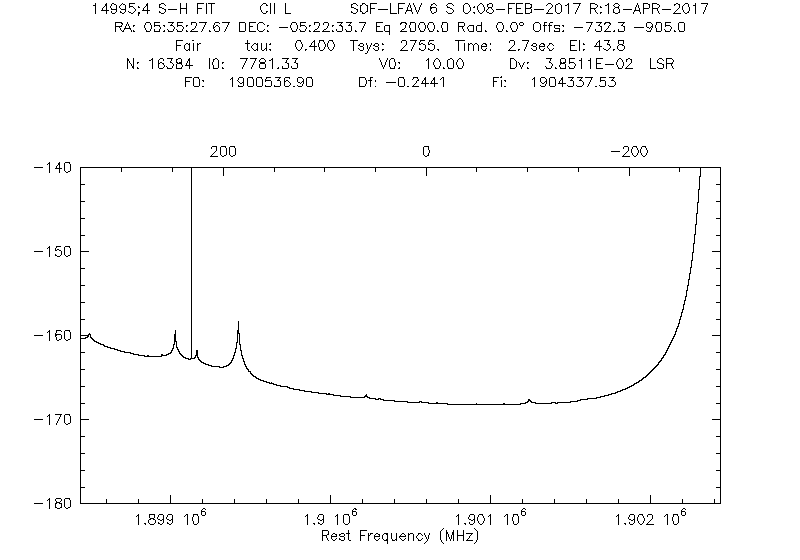

In [79]:
output=RunClassScript(cmd)


## example TAU_SIGNAL spectra ##

In [80]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
get 14990
pl
ha "./tmp/plots/tau_signal.png" /dev png /overwr
'''

'./tmp/plots/tau_signal.png'

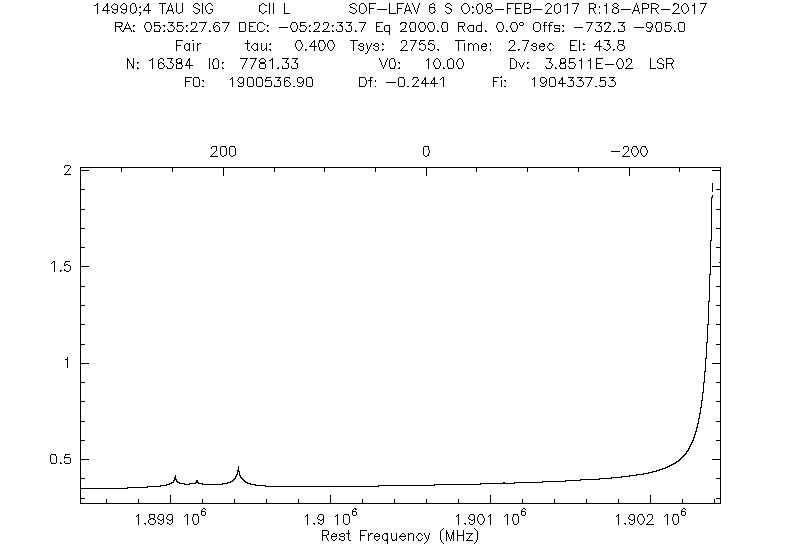

In [81]:
output=RunClassScript(cmd)


# Converting from T<sub>ant</sub> to T<sub>mb</sub> #

In [26]:
cmd ='''
file in "./tmp/data/2017-02-08_GR_F371_04_0066_0010505_1900536.9/2017-02-08_GR_F371_04_0066_0010505_1900536.9_Tant.great"
find
file out "./tmp/sofia_school_Tmb.great" single /overwr
set source OMC_CENTER
find

def struct teles_all
list /toc tel /var teles_all

def real mb_values[21]

let mb_values 0.66 0.64 0.67 0.69 0.65 0.66 0.68 0.63 0.64 0.66 0.63 0.64 0.64 0.65 0.65 0.66 0.69 0.69 0.70 0.65 0.70

def int mb_counter
let mb_counter = 1
set unit v
set win -90 -70
set align v

for telescope /in teles_all%tele
    set tele 'telescope'
    find
    say 'telescope'
    say 'mb_counter'
    for i 1 to found
        get next
        modify beam_eff mb_values[mb_counter]
        base 1
        wr
    next
    let mb_counter 'mb_counter'+1
next

del /var teles_all

'''

In [27]:
output=RunClassScript(cmd)

# main beam temperature T<sub>mb</sub> file #

In [194]:
cmd='''
file in "./tmp/sofia_school_Tmb.great"
find
list
'''

In [195]:
output=RunClassScript(cmd)

In [196]:
show_file_content('/tmp/cmd.log', 100)

14013;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +134.5 Eq 18251 6

14014;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +139.7 Eq 18251 6

14015;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +144.9 Eq 18251 6

14016;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +150.1 Eq 18251 6

14017;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +155.3 Eq 18251 6

14018;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +160.5 Eq 18251 6

14019;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +165.7 Eq 18251 6

14020;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +170.9 Eq 18251 6

14021;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +176.1 Eq 18251 6

14022;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +181.3 Eq 18251 6

14023;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +186.5 Eq 18251 6

14024;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +191.7 Eq 18251 6

14025;5 OMC_CENTER   CII_L        SOF-LFAV_6_S   +210.1   +196.9 Eq 18251 6


# LEVEL 4 DATA#
## Consists of **.great** files that are a combination of level 3 data products ##
- Averaged spectra (**.great**)
- Datacubes (**.lmv**)

### Averaged Pixels  ###
### Horizontal and Vertical polarizations separated ###

In [49]:
cmd = '''
file in "./tmp/sofia_school_Tmb.great"
find

file out "./tmp/sofia_school_average_LFA_H_V.great" single /overwr

set def
find
set line CII_L
set teles SOF-LFA*
find
set align v
set nomatch

for i 0 to 6
    set tele SOF-LFAH*'i'*
    find
    average /resample
    wr
next

for i 0 to 6
    set tele SOF-LFAV*'i'*
    find
    average /resample
    wr
next

'''

In [50]:
output=RunClassScript(cmd)

In [197]:
cmd = '''
file in "./tmp/sofia_school_average_LFA_H_V.great"
find
list
'''

In [198]:
output=RunClassScript(cmd)

In [199]:
show_file_content("/tmp/cmd.log",14)

 1;1 OMC_CENTER   CII_L        SOF-LFAH_0_S   -187.2   -216.3 Eq 18247 2

 2;1 OMC_CENTER   CII_L        SOF-LFAH_1_S   -177.0   -245.6 Eq 18247 2

 3;1 OMC_CENTER   CII_L        SOF-LFAH_2_S   -206.1   -240.0 Eq 18247 2

 4;1 OMC_CENTER   CII_L        SOF-LFAH_3_S   -217.2   -209.8 Eq 18247 2

 5;1 OMC_CENTER   CII_L        SOF-LFAH_4_S   -195.6   -186.0 Eq 18247 2

 6;1 OMC_CENTER   CII_L        SOF-LFAH_5_S   -164.1   -192.3 Eq 18247 2

 7;1 OMC_CENTER   CII_L        SOF-LFAH_6_S   -156.5   -221.9 Eq 18247 2

 8;1 OMC_CENTER   CII_L        SOF-LFAV_0_S   -183.7   -215.2 Eq 18247 2

 9;1 OMC_CENTER   CII_L        SOF-LFAV_1_S   -174.1   -245.1 Eq 18247 2

10;1 OMC_CENTER   CII_L        SOF-LFAV_2_S   -204.4   -236.3 Eq 18247 2

11;1 OMC_CENTER   CII_L        SOF-LFAV_3_S   -214.3   -206.3 Eq 18247 2

12;1 OMC_CENTER   CII_L        SOF-LFAV_4_S   -195.0   -183.8 Eq 18247 2

13;1 OMC_CENTER   CII_L        SOF-LFAV_5_S   -164.2   -187.8 Eq 18247 2

14;1 OMC_CENTER   CII_L        SOF-LFA

In [90]:
cmd ='''
@kosma-init
file in "./tmp/sofia_school_average_LFA_H_V.great"
find
list

set unit v
set mod x -40 40
set mod y -30 130

plot_group /group_by telescope /group_by line /smooth 50 /base 3
ha "./tmp/plots/average_h_v.png" /dev png /overwr
'''

'./tmp/plots/average_h_v.png'

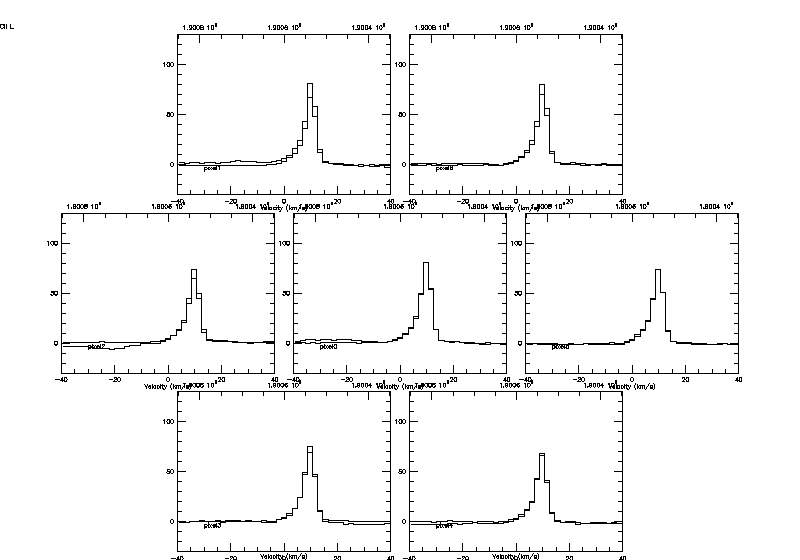

In [91]:
output=RunClassScript(cmd)

### Averaged Pixels  ###
### Horizontal and Vertical polarizations averaged together ###

In [92]:
cmd='''
file in "./tmp/sofia_school_Tmb.great"
find

file out "./tmp/sofia_school_average_LFA_HVtogether.great" single /overwr

set align v
set nocheck
set telescope SOF-LFA*
find
for i 0 to 6
    set tele SOF-LFA*'i'*
    find
    average /resample
    wr
next

'''

In [93]:
output=RunClassScript(cmd)

In [200]:
cmd='''
file in "./tmp/sofia_school_average_LFA_HVtogether.great"
find 
list
'''

In [201]:
output=RunClassScript(cmd)

In [202]:
show_file_content("/tmp/cmd.log")

I-FIND,  7 observations found

Current index contains:

N;V Source       Line         Telescope      Lambda     Beta Sys  Sca Sub

1;1 OMC_CENTER   CII_L        SOF-LFA-_0_S   -187.2   -216.3 Eq 18247 2

2;1 OMC_CENTER   CII_L        SOF-LFA-_1_S   -177.0   -245.6 Eq 18247 2

3;1 OMC_CENTER   CII_L        SOF-LFA-_2_S   -206.1   -240.0 Eq 18247 2

4;1 OMC_CENTER   CII_L        SOF-LFA-_3_S   -217.2   -209.8 Eq 18247 2

5;1 OMC_CENTER   CII_L        SOF-LFA-_4_S   -195.6   -186.0 Eq 18247 2

6;1 OMC_CENTER   CII_L        SOF-LFA-_5_S   -164.1   -192.3 Eq 18247 2

7;1 OMC_CENTER   CII_L        SOF-LFA-_6_S   -156.5   -221.9 Eq 18247 2



In [97]:
cmd ='''
@kosma-init
file in "./tmp/sofia_school_average_LFA_HVtogether.great"
find
list

set unit v
set mod x -40 40
set mod y -30 130

plot_group /group_by telescope /group_by line /smooth 50 /base 3
ha "./tmp/plots/average_h_v.png" /dev png /overwr
'''

'./tmp/plots/average_h_v.png'

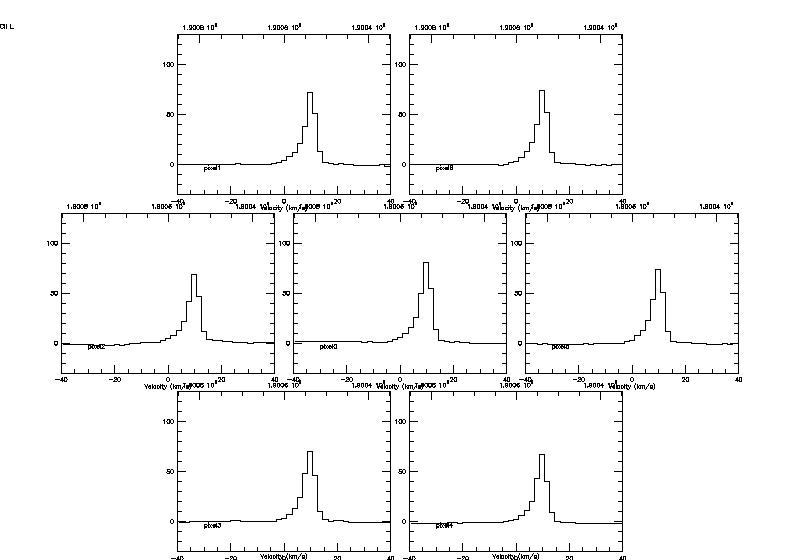

In [98]:
output=RunClassScript(cmd)

# generate average pixel plot

In [117]:
class_script='''
set def
@kosma-init
file in "{filename}"
find
set unit v
set mode x {min_x} {max_x}
set mode y {min_y} {max_y}
set line {line}
set source {source}
set window {window}
set align v

find 

go where
draw t 15 20 {plot_filename} 6
ha "{plot_filename}_go_where.png" /dev png /overwrite

plot_group /group_by telescope
draw t 15 20 {plot_filename} 6
ha "{plot_filename}" /dev png /overwrite
'''

In [118]:
plots_folder = "tmp/plots"
os.makedirs(plots_folder,exist_ok=True)
#
class_cmd = {}
class_cmd['min_x'] = -40
class_cmd['max_x'] = 40
class_cmd['min_y'] = -30
class_cmd['max_y'] = 130
class_cmd['smooth'] = 10
class_cmd['line'] = "CII_L"
class_cmd['source'] = "OMC_CENTER"
class_cmd['window'] = "-20 20"

#already_downloaded_great = glob.glob("tmp/data/**/*.great")
already_downloaded_great = glob.glob("tmp/*Tmb.great")
images = []
for class_filename in already_downloaded_great:
    print(class_filename)
    class_cmd["filename"] = os.path.abspath(class_filename)    
    class_cmd["plot_filename"] = "{0}/plot_group_{1}.png".format(plots_folder,os.path.basename(class_filename))
    print(class_cmd["plot_filename"])
    cmd=class_script.format(**class_cmd)
    output = RunClassScript(cmd, no_output=False,display_images=False)
    images.extend(output.images)
message = "Test message"
PrintMessage(message)
DisplayImagesInColumns(images,2,'test_gallery')

tmp/sofia_school_Tmb.great
tmp/plots/plot_group_sofia_school_Tmb.great.png


Test message


'    \n    <a href=tmp/plots/plot_group_sofia_school_Tmb.great.png_go_where.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'tmp/plots/plot_group_sofia_school_Tmb.great.png_go_where.png?1643715839.2729707\' />\n    </a>\n        \n    \n    <style>\n    .thumb img { \n        border:1px solid #000;\n        margin:3px;    \n        float:left;\n    }\n    .thumb span { \n        position:fixed;\n        visibility:hidden;\n    }\n    .thumb:hover, .thumb:hover span { \n        visibility:visible;\n        z-index:1;\n    }\n\n    </style>\n\n        \n    <a href=tmp/plots/plot_group_sofia_school_Tmb.great.png  target="_blank">\n    <img style=\'width: 48%; margin: 0px; float: left; border: 0px solid black;\' src=\'tmp/plots/plot_group_sofia_school_Tmb.great.png?1643715839.272984\' />\n    </a>\n    '

# Generate overview plots
Here is an example of simple script to plot a single class spectra and display this in the notebook

# WORKING ON FITS FILES #
## Cygrid  ##

### Creating the fits file from class ###

In [182]:
cmd='''
set angle sec
file in sofia_school_Tmb.great 
find
fits write sofia_school_Tmb_index.fits /mode index
'''

In [183]:
#output=RunClassScript(cmd)

In [131]:
class RawData:
    def __init__(self, fits_file):
        self.fits_file = fits_file
                 
        self.listremdframe = np.empty(0, dtype = int)
        self.lint = False                                                   
        self.rms = False

        with fits.open(self.fits_file) as hdu:
            self.data_fits = hdu[1].data
            self.header = hdu[1].header
        self.data = self._to_numpy()
        self.ra = self.data[:, 3] + self.header['CRVAL2']
        self.dec = self.data[:, 4] + self.header['CRVAL3']
        self.specs = np.nan_to_num(np.array(self.data[:, -1].tolist()))
        self.ra_min, self.ra_max = self.ra.min(), self.ra.max()
        self.dec_min, self.dec_max = self.dec.min(), self.dec.max()

        
    def _to_numpy(self):
        return np.array(self.data_fits.tolist())

    def _to_pandas(self):
        self.data = pd.DataFrame(data=self.data,
            columns=[self.data_fits.columns[i].name for i in range(len(self.data_fits.columns))])
        
    def cygrid_define(self, ra, dec, header, pixsize = 0.0004, kernelsize_sigma = 0.0002):
        '''cygrid params definition'''
        mapcenter = header['CRVAL2'], header['CRVAL3']  
        dnaxis1 = int((ra.max() - ra.min())/pixsize)+1
        dnaxis2 = int((dec.max() - dec.min())/pixsize)+1
        crpix1 = (ra.max() - mapcenter[0])/pixsize
        crpix2 = (mapcenter[1] - dec.min())/pixsize

        kernel_type = 'gauss1d'
        kernel_params = (kernelsize_sigma, )
        kernel_support = 3.0 * kernelsize_sigma
        hpx_maxres = kernelsize_sigma / 2.0

        header_out = {'NAXIS': 3,
              'NAXIS1': dnaxis1,
              'NAXIS2': dnaxis2,
              'NAXIS3': 301,
              'CTYPE1': 'RA---GLS',
              'CTYPE2': 'DEC--GLS',
              'CUNIT1': 'deg',
              'CUNIT2': 'deg',
              'CDELT1': -pixsize,
              'CDELT2': pixsize,
              'CRPIX1': crpix1,
              'CRPIX2': crpix2,
              'CRVAL1': mapcenter[0],
              'CRVAL2': mapcenter[1]
             }
        return header_out, kernel_type, kernel_params, kernel_support, hpx_maxres
    
    
    
    def mygridder(self, data):
        if isinstance(data, pd.DataFrame):
            data = data.to_numpy()
        ra = data[:, 3] + self.header['CRVAL2']
        dec = data[:, 4] + self.header['CRVAL3']
        print( self.header['CRVAL2'],  self.header['CRVAL3'])
        print(ra, dec)
        specs = np.nan_to_num(np.array(data[:, -1].tolist()))
        header_map, kernel_type, kernel_params, kernel_support, hpx_maxres = self.cygrid_define(
                    ra, dec, self.header, pixsize = 0.001, kernelsize_sigma = 0.0005)
        mygridder = cygrid.WcsGrid(header_map)
        mygridder.set_kernel(kernel_type, kernel_params, kernel_support, hpx_maxres)
        mygridder.grid(ra, dec, specs[:, 100: -100])
        gridded_map = mygridder.get_datacube()
        target_wcs = mygridder.get_wcs()
        return gridded_map, target_wcs

    def my3gridder(self):
        self.gridded_map, self.target_wcs =  self.mygridder(self.data)

In [153]:

filename="./tmp/sofia_school_Tmb_index.fits"
data= RawData(filename)

<ipython-input-131-b5aa8c870359>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self.data_fits.tolist())


In [156]:
data.my3gridder()

83.865292 -5.376028
[83.81328352389168 83.81328352389168 83.81328352389168 ...
 83.92510250431728 83.92510250431728 83.92510250431728] [-5.436108103576183 -5.4346636595158575 -5.433219215455532 ...
 -5.319770252886295 -5.3183258088259695 -5.316881364765644]


<ipython-input-131-b5aa8c870359>:72: RuntimeWarning: invalid value encountered in true_divide
  gridded_map = mygridder.get_datacube()


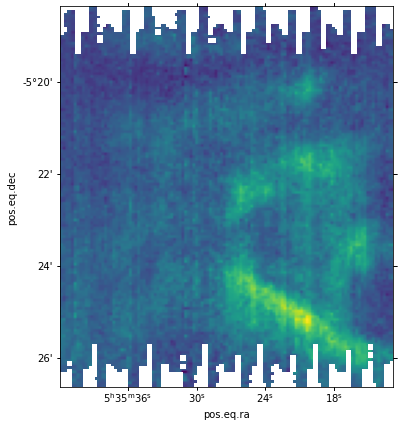

In [181]:
ax0 = plt.subplot(projection=data.target_wcs.celestial)
im0 = ax0.imshow(data.gridded_map[7700])